<a href="https://colab.research.google.com/github/soujanya-vattikolla/Deeplearning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import required libraries
import os
import tarfile
import urllib
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

# Downloading the Dataset
urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz', 'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']


def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)


def cats_vs_dogs_annotations(file_path):
    annotations = {}
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()


    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        image_name += '.jpg'
        if image_name[0].lower() != image_name[0]:
            class_name = 'cat'
        else:
            class_name = 'dog'
        annotations[image_name] = class_name
    
    return annotations, i + 1


def display_examples(x, y, p, images, index_to_class):


    print('Displaying first 8 examples..')


    if len(images) < 8:
        print('Need at least 8 examples')
        return None


    plt.figure(figsize=(12, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        gt = int(np.squeeze(y[i]) > 0.5)
        pred = int(np.squeeze(p[i]) > 0.5)
        col = 'green' if gt == pred else 'red'
        plt.xlabel(index_to_class[pred], color=col)
    return plt

download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


In [2]:
# Data Pre-Processing

%matplotlib inline


data_dir = 'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)


print('TensorFlow version:', tf.__version__)

print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.8.2
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? True


In [3]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}


train_annot, count_train = cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot, count_test = cats_vs_dogs_annotations('data/annotations/test.txt')


print('Training examples count:', count_train)
print('Test examples count:', count_test)

Training examples count: 3680
Test examples count: 3669


0 belongs to a Cat and 1 belongs to a Dog

In [4]:
# Random Batch is to take the annotation dictionary and return some randomly selected examples from our Dataset.
image_dir = 'data/images/'


def get_random_batch(annot, batch_size=4):
    all_keys = list(annot.keys())
    total_examples = len(all_keys)
    indices = np.random.choice(range(total_examples), batch_size)
    x = np.zeros((batch_size, 128, 128, 3))
    y = np.zeros((batch_size, 1))
    images = []
    
    for i, index in enumerate(indices):
        image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, all_keys[index]),
                                                     target_size=(128, 128))
        images.append(image)
        arr = tf.keras.preprocessing.image.img_to_array(image)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        arr = np.expand_dims(arr, axis=0)
        x[i] = arr
        y[i] = class_to_index[annot[all_keys[index]]]
    
    return x, y, images

Displaying first 8 examples..


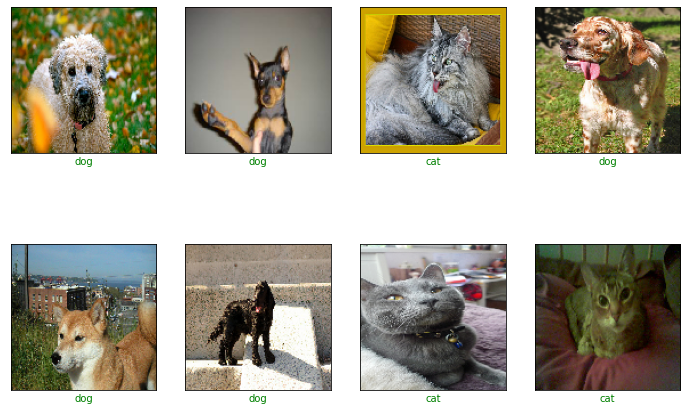

In [5]:
x, y, images = get_random_batch(train_annot, batch_size=8)

display_examples(x, y, y, images, index_to_class).show()

In [6]:
# Data Modelling
# using MobileNet v2 as our Baseline Model 
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, 
                                                      input_shape=(128, 128, 3),
                                                      pooling='avg',
                                                      weights='imagenet')

mnet.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [7]:
# Build the model
# 1.Sequential Model from Keras
# 2.MobileNet architecture 
# 3.Dropout Layer 
# 4. Dense Layer

def create_model():
    model = tf.keras.models.Sequential([
        mnet,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    model.layers[0].trainable = False
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model


model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
# Data Generator Function which takes in the Batch Size and Annotation as function parameters and pass the Data. 
# We can use this in our Fit Generator Function and can fetch random bathes from our Dataset
def data_generator(batch_size, annot):
    while True:
        x, y, _ = get_random_batch(annot, batch_size)
        
        yield (x,y)

In [9]:
# define the batch size along with steps per epoch and validation steps. 
batch_size = 32
steps_per_epoch = int(len(list(train_annot.keys()))/batch_size)
validation_steps = int(len(list(test_annot.keys()))/batch_size)

print('Steps per epoch:', steps_per_epoch)
print('Validation steps:', validation_steps)

Steps per epoch: 115
Validation steps: 114


In [10]:
# fit our Model by using the fit_generator() function 
%%time


_ = model.fit_generator(
    data_generator(batch_size, train_annot),
    validation_data=data_generator(batch_size, test_annot),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=1
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


115/115 [==============================] - 43s 304ms/step - loss: 0.2756 - acc: 0.8886 - val_loss: 0.1025 - val_acc: 0.9718
CPU times: user 43 s, sys: 1.83 s, total: 44.9 s
Wall time: 45.4 s


Displaying first 8 examples..


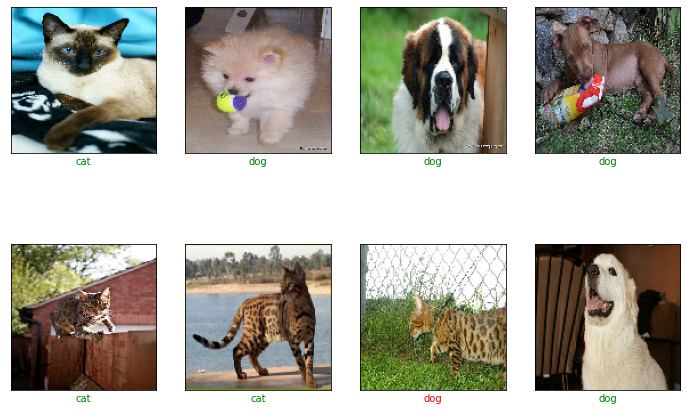

In [11]:
# Predictions
x, y, images = get_random_batch(test_annot, batch_size=8)
preds = model.predict(x)
display_examples(x, y, preds, images, index_to_class).show()